<div style="float:left">
    <h1 style="width:600px">Workshop 9: Deep learning for unstructured data with fast.ai</h1>
    <h3 style="width:600px">CASA0006: Data Science for Spatial Systems</h3>
    <h3 style="width:600px">Author: Huanfa Chen</h3>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

In this workshop, we'll see how fast.ai allows you to use the same API to solve a range of deep learning problems with unstructured data, such as vision or text. We'll go over a lot of different tasks and each time, grab some data in a [`DataBunch`](https://docs.fast.ai/basic_data.html#DataBunch) with the [data block API](https://docs.fast.ai/data_block.html), see how to get a look at a few inputs with the `show_batch` method, train an appropriate [`Learner`](https://docs.fast.ai/basic_train.html#Learner) then use the `show_results` method to see what the outputs of our model actually look like.

The fast.ai library is developed by the fast.ai, a non-profit research group focused on deep learning and artificial intelligence. It was founded by by Jeremy Howard and Rachel Thomas with the goal of *democratising deep learning* in 2016. The group do this in several ways:

- Free courses for coders: the free Massive Open Online Course (MOCC) "Practical Deep Learning for Coders".
- Easy-to-use software library: fast.ai library, which is based on the PyTorch framework.
- Cutting-edge research
- Community

The slogan of fast.ai is *Making neural nets uncool again*. More details are [here](https://www.fast.ai/about/):

```
Being cool is about being exclusive, and that’s the opposite of what we want. We want to make deep learning as accessible as possible– including to people using uncool languages like C#, uncool operating systems like Windows (which is used by the majority of the world), uncool datasets (way smaller than anything at Google, and in domain areas you’d consider obscure), and with uncool backgrounds (maybe you didn’t go to Stanford).
```


A few facts about fast.ai:
* It is an easy to use deep learning library in Python
* It is built on top of PyTorch, one of the most popular deep learning frameworks developed by Facebook
* fast.ai also comes with a [free deep learning crash course](https://course.fast.ai/) which you might want to explore afterwards!
* fast.ai is one of the **four** most popular deep learning frameworks shown below.

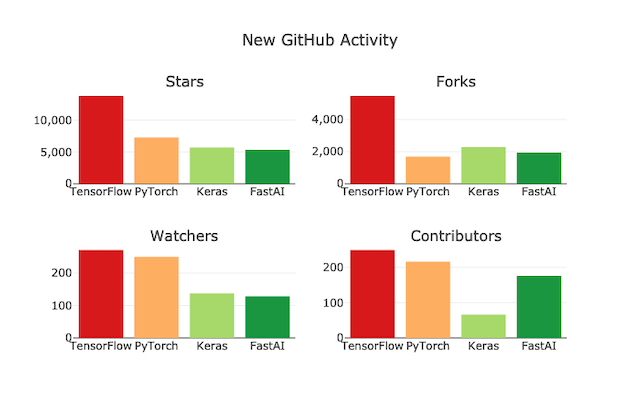

Fast.ai contain separate modules for different types of data: *vision*, *text* or *tabular*. Each module is a set of ready-to-use functions to load data, select a suitable model and train the model. For more information, read the documentation [here](https://fastai1.fast.ai/applications.html).

Before we start, please install the fast.ai library according to the instructions [here](https://github.com/fastai/fastai/blob/master/README.md#installation) but with some changes. 

If you are using Conda, you should simply run the following command in your terminal (note that you need to replace *your_env_name* with your own environment): 

```
    conda activate [your_env_name, e.g. sds2020]
    conda install -c pytorch -c fastai fastai=1.*
```

These commands may activate your environment, and then install fastai (version 1.0.61 or similar) while updating a list of other packages. Type 'y' to proceed if you are asked 'Procedd?\[y/n\]'.

Please make sure that you are using fastai v1 for this workshop. The APIs of fastai have changed dramatically between v1 and v2 (the current version).

After the installation, you may check the installed version of **fastai** using the following command (for Linux/Mac):

```
conda list | grep fastai
```

If you are using Windows cmd, an alternative command would be:
```
conda list | findstr fastai
```

The version should be 1.\*. If you have installed v2, please rerun the installation command to get v1.

In [1]:
from fastai.basics import *
from fastai.gen_doc.nbdoc import *
# defaults.device = torch.device('cpu')

ModuleNotFoundError: No module named 'fastai'

## Vision

To quickly get access to all the vision functions inside fastai, we use the usual import statements.

In [10]:
from fastai.vision import *

### A classification problem

Let's begin with our sample of the MNIST dataset.

In [11]:
mnist = untar_data(URLs.MNIST_TINY)
tfms = get_transforms(do_flip=False)

Print the value of URLs.MNIST_TINY to see where the data is downloaded from.

In [12]:
print(URLs.MNIST_TINY)

http://files.fast.ai/data/examples/mnist_tiny


In [13]:
mnist

WindowsPath('C:/Users/Huanfa Chen/.fastai/data/mnist_tiny')

Check where the data is saved by default.

It's set up with an ImageNet structure so we use it to load our training and validation datasets, then label, transform, convert them into ImageDataBunch and finally, normalize them.

In [14]:
data = (ImageList.from_folder(mnist)
        .split_by_folder()          
        .label_from_folder()
        .transform(tfms, size=32)
        .databunch(num_workers=0)
        .normalize(imagenet_stats))

Once your data is properly set up in a [`DataBunch`](/basic_data.html#DataBunch), we can call `data.show_batch()` to see what a sample of a batch looks like.

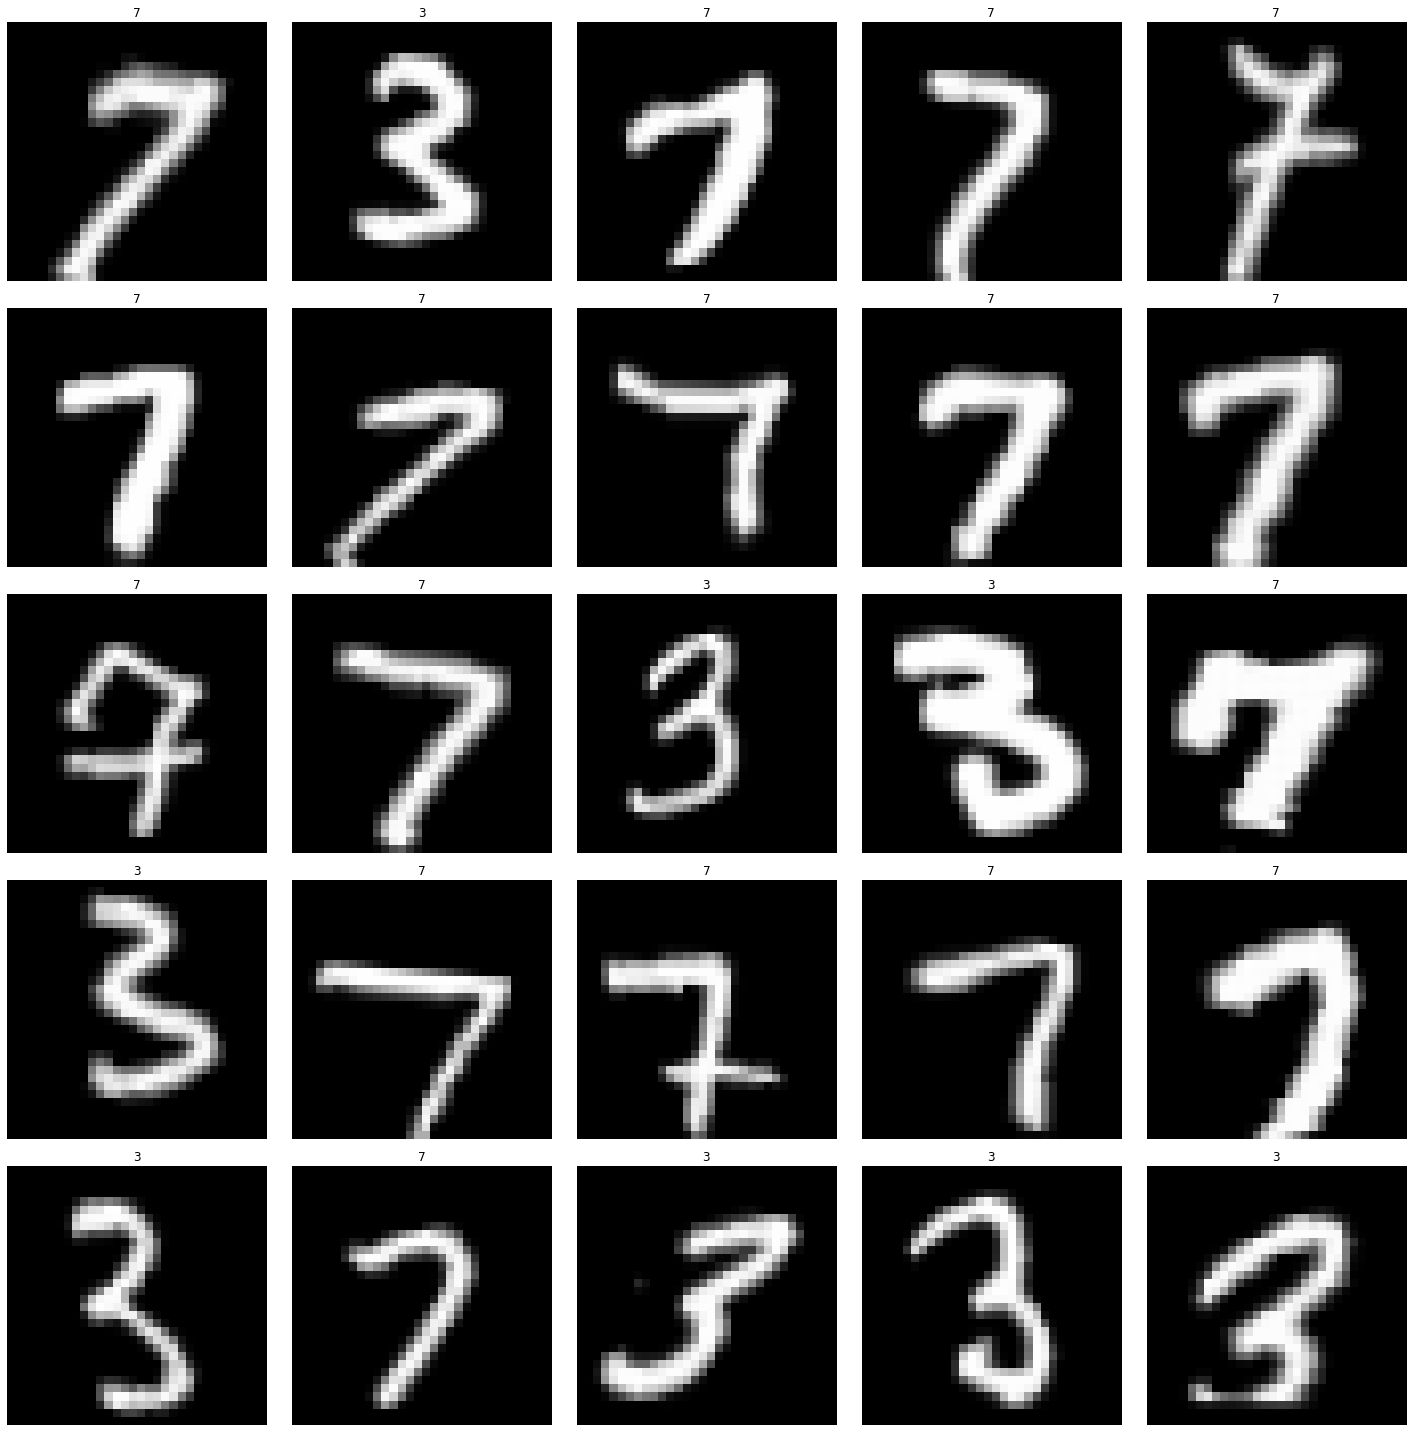

In [15]:
data.show_batch()

Note that the images were automatically de-normalized before being showed with their labels (inferred from the names of the folder). We can specify a number of rows if the default of 5 is too big, and we can also limit the size of the figure.

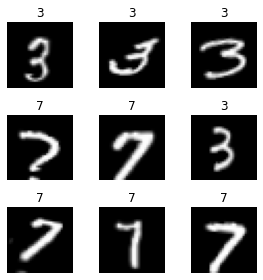

In [16]:
data.show_batch(rows=3, figsize=(4,4))

Now let's create a [`Learner`](https://docs.fast.ai/vision.learner.html) object to train a classifier. 

In [17]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.fit_one_cycle(1,1e-2)
learn.save('mini_train')

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to C:\Users\Huanfa Chen/.cache\torch\hub\checkpoints\resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,time
0,0.659053,0.206897,0.934192,00:15


Our model has quickly reached around 91% accuracy, now let's see its predictions on a sample of the validation set. For this, we use the `show_results` method.

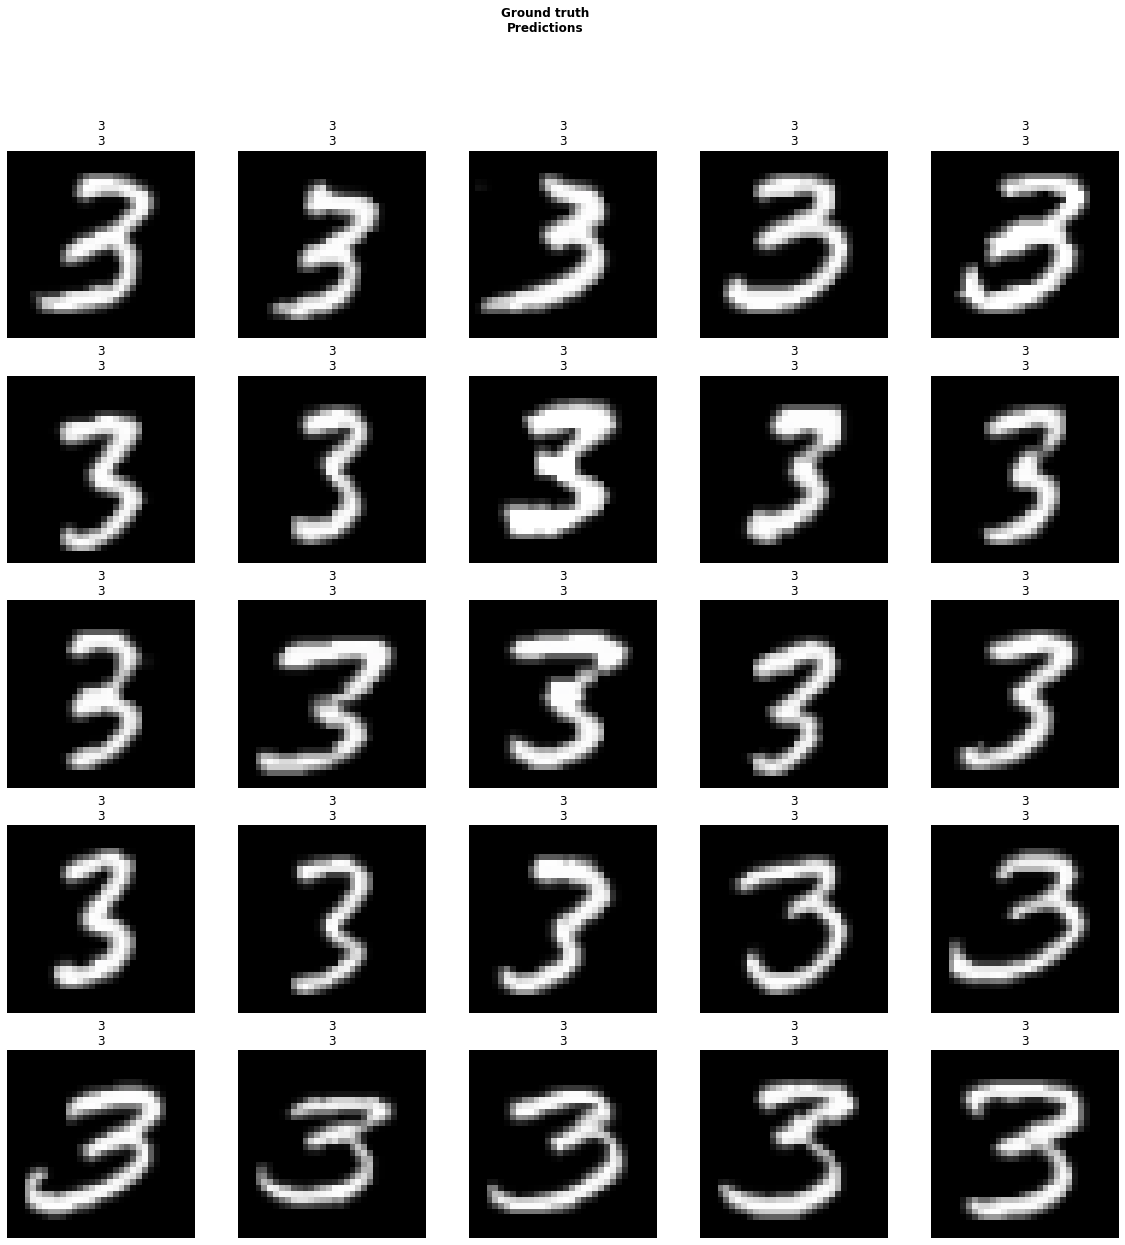

In [18]:
learn.show_results()

Since the validation set is usually sorted, we get only images belonging to the same class. We can then again specify a number of rows, a figure size, but also the dataset on which we want to make predictions.

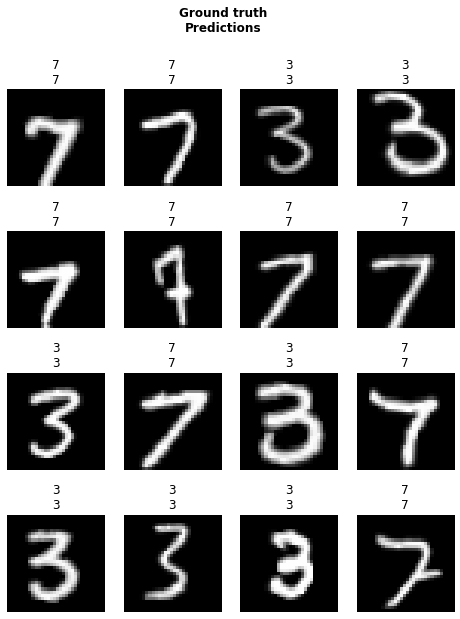

In [19]:
learn.show_results(ds_type=DatasetType.Train, rows=4, figsize=(8,10))

### A multilabel problem

Now let's try these on the planet dataset, which is a little bit different in the sense that each image can have multiple tags (and not just one label).

In [20]:
planet = untar_data(URLs.PLANET_TINY)
planet_tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

Here each images is labelled in a file named 'labels.csv'. We have to add 'train' as a prefix to the filenames, '.jpg' as a suffix and the labels are separated by spaces.

In [21]:
data = (ImageList.from_csv(planet, 'labels.csv', folder='train', suffix='.jpg')
        .split_by_rand_pct()
        .label_from_df(label_delim=' ')
        .transform(planet_tfms, size=128)
        .databunch(num_workers=0)
        .normalize(imagenet_stats))

C:\Users\Huanfa Chen\Anaconda3\envs\sds2020\lib\site-packages\fastai\core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


And we can have look at our data with `data.show_batch`.

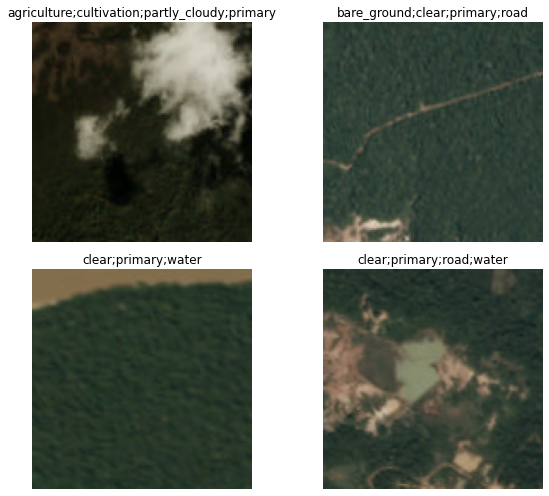

In [22]:
data.show_batch(rows=2, figsize=(9,7))

Then we can then create a [`Learner`](/basic_train.html#Learner) object pretty easily and train it for a little bit.

In [23]:
learn = cnn_learner(data, models.resnet18)
learn.fit_one_cycle(5,1e-2)
learn.save('mini_train')

epoch,train_loss,valid_loss,time
0,1.042735,0.793998,00:07
1,0.965831,0.870058,00:05
2,0.905251,0.670800,00:05
3,0.853824,0.671890,00:05
4,0.811922,0.624809,00:05


And to see actual predictions, we just have to run `learn.show_results()`.

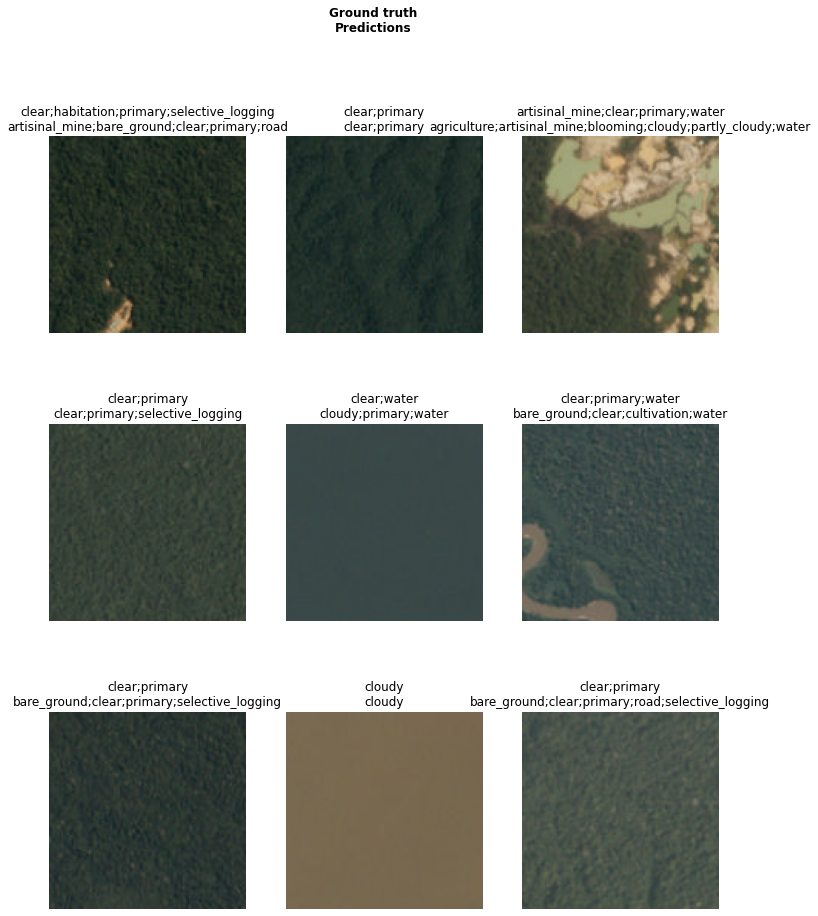

In [24]:
learn.show_results(rows=3, figsize=(12,15))

### A regression example

For the next example, we are going to use the [BIWI head pose](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db) dataset. On pictures of persons, we have to find the center of their face. For the fastai docs, we have built a small subsample of the dataset (200 images) and prepared a dictionary for the correspondance filename to center.

In [25]:
biwi = untar_data(URLs.BIWI_SAMPLE)
fn2ctr = pickle.load(open(biwi/'centers.pkl', 'rb'))

To grab our data, we use this dictionary to label our items. We also use the [`PointsItemList`](/vision.data.html#PointsItemList) class to have the targets be of type [`ImagePoints`](/vision.image.html#ImagePoints) (which will make sure the data augmentation is properly applied to them). When calling [`transform`](/tabular.transform.html#tabular.transform) we make sure to set `tfm_y=True`.

In [26]:
data = (PointsItemList.from_folder(biwi)
        .split_by_rand_pct(seed=42)
        .label_from_func(lambda o:fn2ctr[o.name])
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch(num_workers=0)
        .normalize(imagenet_stats))

Then we can have a first look at our data with `data.show_batch()`.

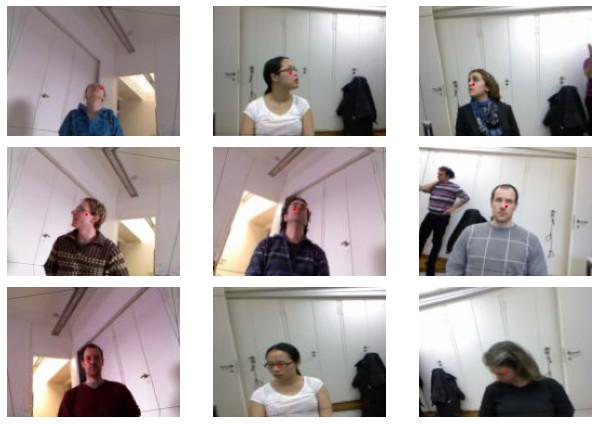

In [27]:
data.show_batch(rows=3, figsize=(9,6))

We train our model for a little bit before using `learn.show_results()`.

In [28]:
learn = cnn_learner(data, models.resnet18, lin_ftrs=[100], ps=0.05)
learn.fit_one_cycle(5, 5e-2)
learn.save('mini_train')

epoch,train_loss,valid_loss,time
0,1.973374,29.408407,00:16
1,5.495705,439.311920,00:07
2,4.609908,208.372513,00:05
3,3.915132,67.437927,00:06
4,3.306879,27.827305,00:06


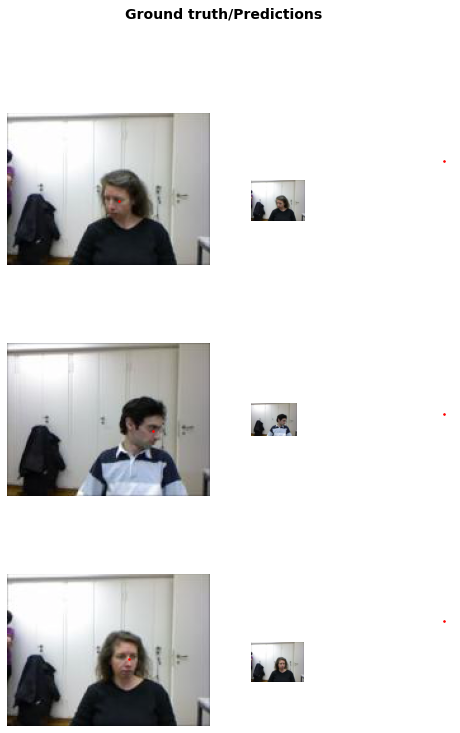

In [29]:
learn.show_results(rows=3)

### A segmentation example

Now we are going to look at the [camvid dataset](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/) (at least a small sample of it), where we have to predict the class of each pixel in an image. Each image in the 'images' subfolder as an equivalent in 'labels' that is its segmentations mask.

In [30]:
camvid = untar_data(URLs.CAMVID_TINY)
path_lbl = camvid/'labels'
path_img = camvid/'images'

We read the classes in 'codes.txt' and the function maps each image filename with its corresponding mask filename.

In [31]:
codes = np.loadtxt(camvid/'codes.txt', dtype=str)
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

The data block API allows us to uickly get everything in a [`DataBunch`](/basic_data.html#DataBunch) and then we can have a look with `show_batch`.

In [32]:
data = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(get_y_fn, classes=codes)
        .transform(get_transforms(), tfm_y=True, size=128)
        .databunch(bs=16, path=camvid, num_workers=0)
        .normalize(imagenet_stats))

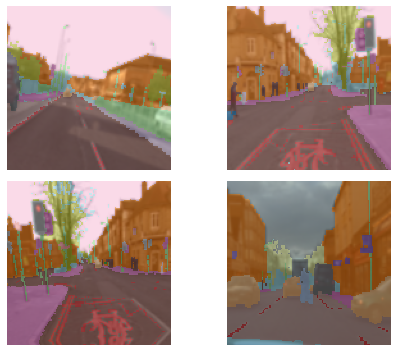

In [33]:
data.show_batch(rows=2, figsize=(7,5))

Then we train a Unet for a few epochs.

In [34]:
jekyll_warn("This training is fairly unstable, you should use more epochs and the full dataset to get better results.")

<div markdown="span" class="alert alert-danger" role="alert"><i class="fa fa-danger-circle"></i> <b>Warning: </b>This training is fairly unstable, you should use more epochs and the full dataset to get better results.</div>

In [35]:
learn = unet_learner(data, models.resnet18)
learn.fit_one_cycle(3,1e-2)
learn.save('mini_train')

epoch,train_loss,valid_loss,time
0,12.851171,3.348433,00:40
1,7.478042,2.164235,00:37
2,5.492081,2.021388,00:36


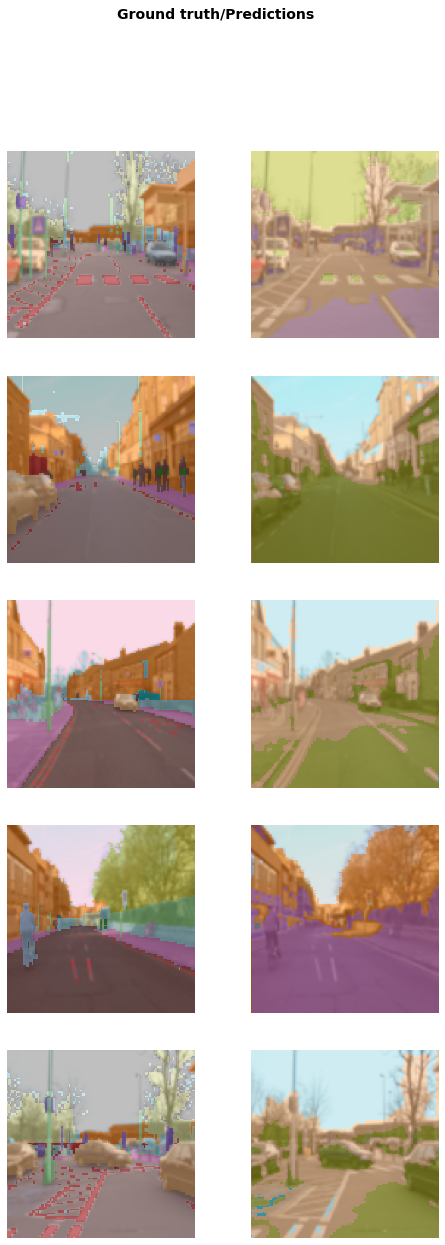

In [36]:
learn.show_results()

## Text

Next application is text, so let's start by importing everything we'll need.

In [37]:
from fastai.text import *

### Language modelling

First we'll fine-tune a pretrained language model on our subset of imdb.

In [38]:
imdb = untar_data(URLs.IMDB_SAMPLE)

In [39]:
defaults.cpus=1 # Reason: https://github.com/fastai/fastai/issues/1850

In [40]:
data_lm = (TextList.from_csv(imdb, 'texts.csv', cols='text')
                   .split_by_rand_pct()
                   .label_for_lm()
                   .databunch(num_workers=0))
data_lm.save()

C:\Users\Huanfa Chen\Anaconda3\envs\sds2020\lib\site-packages\fastai\core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


`data.show_batch()` will work here as well. For a language model, it shows us the beginning of each sequence of text along the batch dimension (the target being to guess the next word).

In [41]:
data_lm.show_batch()

C:\Users\Huanfa Chen\Anaconda3\envs\sds2020\lib\site-packages\fastai\text\data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:882.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,! ! ! xxmaj finally this was directed by the guy who did xxmaj big xxmaj xxunk ? xxmaj must be a xxunk of xxmaj jonestown - hollywood style . xxmaj xxunk ! xxbos xxmaj every once in a long while a movie will come along that will be so awful that i feel compelled to warn people . xxmaj if i labor all my days and i can save
1,"a grand voyage for the audience as well as the two principals . xxmaj the imagery throughout is impressive , especially the final scenes in xxmaj xxunk . xxmaj it xxunk for me once again how much different the world can be , but also at the same time , how similar . xxmaj the same was true for the father and son in this film . \n \n"
2,"xxunk between the xxunk -- resulting in a xxup we vs. xxup they mentality . xxmaj later , an explosion causes a huge xxunk in the xxmaj french and the xxmaj xxunk refuse to sit back and do nothing . xxmaj xxunk their own lives , they prove that there is true xxunk between miners and men in general . \n \n xxmaj the film is a strong criticism"
3,"put the camera man on roller xxunk and pushed him along . xxmaj the story ( if it can be called that ) is so full of holes it 's almost funny , xxmaj it never really explains why the hell he survived in the first place , or needs human flesh in order to survive . xxmaj the script is poorly written and the dialogue xxunk on just plane"
4,"them and insults them because they play woods and blah blah blah xxmaj the phantom helps these xxunk kids out and trains them and all this crap , he gets them to play airball and basically xxunk all the xxunk including the "" xxunk "" . \n \n xxmaj so what exactly is wrong with the movie ? xxmaj well the budget is a huge thing , a paintball"


Now let's define a language model learner

In [42]:
learn = language_model_learner(data_lm, AWD_LSTM)
learn.fit_one_cycle(2, 1e-2)
learn.save('mini_train_lm')
learn.save_encoder('mini_train_encoder')

epoch,train_loss,valid_loss,accuracy,time
0,4.354847,3.764436,0.291220,04:30
1,4.083474,3.738161,0.294970,04:25


Then we can have a look at the results. It shows a certain amount of words (default 20), then the next 20 target words and the ones that were predicted.

In [43]:
learn.show_results()

text,target,pred
xxbos xxmaj this is one of those movies that 's difficult to review without giving away the plot . xxmaj,"xxunk to say there are weird things and unexpected twists going on , beyond the initial xxunk "" xxmaj tom","it is the that 's a things about n't xxunk and on , but the xxunk xxunk of . xxunk"
"we are going to green light ! ! "" xxmaj and whoever that person is , should have his or",her head examined for actual brain xxunk . xxmaj because whoever is responsible for actually xxunk out money to have,"her xxunk xxunk . a xxunk xxunk . xxmaj the of is xxunk for the xxunk the the , make"
a society which is supposedly gone and yet somehow is still with us . xxbos xxmaj for those who like,"their murder xxunk busy , this is definitely the one to see , as it is xxunk full of interesting","this xxunk , , , xxmaj is a a best that watch . but the is a . of xxunk"
awhile but not all of them get the treatment they deserve . xxmaj the nice supporting cast includes xxmaj xxunk,"xxmaj xxunk , at his best in a xxunk comic performance as a xxunk xxunk , xxmaj xxunk xxmaj xxunk","xxmaj xxunk , xxmaj least best , the xxunk , book , xxmaj xxunk , , and xxunk xxmaj xxunk"
"xxmaj as such , when i first heard about the xxunk of a prequel series some months ago i got",a sick feeling in my xxunk . i was afraid that the formula that made xxmaj xxunk so successful would,a lot boy of the eyes . xxmaj was so that i movie was i this xxunk xxmaj bad was


### Classification

Now let's see a classification example. We have to use the same vocabulary as for the language model if we want to be able to use the encoder we saved.

In [44]:
data_clas = (TextList.from_csv(imdb, 'texts.csv', cols='text', vocab=data_lm.vocab)
                   .split_from_df(col='is_valid')
                   .label_from_df(cols='label')
                   .databunch(bs=42,num_workers=0))

C:\Users\Huanfa Chen\Anaconda3\envs\sds2020\lib\site-packages\fastai\core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


C:\Users\Huanfa Chen\Anaconda3\envs\sds2020\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Here show_batch shows the beginning of each review with its target.

In [45]:
data_clas.show_batch()

text,target
"xxbos xxmaj xxunk xxmaj victor xxmaj xxunk : a xxmaj review \n \n xxmaj you know , xxmaj xxunk xxmaj victor xxmaj xxunk is like sticking your hands into a big , xxunk xxunk of xxunk . xxmaj it 's warm and xxunk , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and xxunk xxmaj xxunk xxmaj",negative
"xxbos xxup the xxup shop xxup around xxup the xxup xxunk is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with",positive
"xxbos xxmaj now that xxmaj che(2008 ) has finished its relatively short xxmaj australian cinema run ( extremely limited xxunk screen in xxmaj xxunk , after xxunk ) , i can xxunk join both xxunk of "" xxmaj at xxmaj the xxmaj movies "" in taking xxmaj steven xxmaj soderbergh to task . \n \n xxmaj it 's usually satisfying to watch a film director change his style /",negative
"xxbos xxmaj this film sat on my xxmaj xxunk for weeks before i watched it . i xxunk a self - indulgent xxunk flick about relationships gone bad . i was wrong ; this was an xxunk xxunk into the xxunk - up xxunk of xxmaj new xxmaj xxunk . \n \n xxmaj the format is the same as xxmaj max xxmaj xxunk ' "" xxmaj la xxmaj xxunk",positive
"xxbos xxmaj many xxunk that this is n't just a classic due to the fact that it 's the first xxup 3d game , or even the first xxunk - up . xxmaj it 's also one of the first xxunk games , one of the xxunk definitely the first ) truly claustrophobic games , and just a pretty well - xxunk gaming experience in general . xxmaj with graphics",positive


And we can train a classifier that uses our previous encoder.

In [46]:
learn = text_classifier_learner(data_clas, AWD_LSTM)
learn.load_encoder('mini_train_encoder')
learn.fit_one_cycle(2, slice(1e-3,1e-2))
learn.save('mini_train_clas')

epoch,train_loss,valid_loss,accuracy,time
0,0.654783,0.632488,0.640000,02:59
1,0.640120,0.607180,0.675000,03:01


C:\Users\Huanfa Chen\Anaconda3\envs\sds2020\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\Huanfa Chen\Anaconda3\envs\sds2020\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype

In [47]:
learn.show_results()

text,target,prediction
"xxbos \n \n i 'm sure things did n't exactly go the same way in the real life of xxmaj homer xxmaj hickam as they did in the film adaptation of his book , xxmaj rocket xxmaj boys , but the movie "" xxmaj october xxmaj sky "" ( an xxunk of the book 's title ) is good enough to stand alone . i have not read xxmaj",positive,negative
"xxbos xxmaj to review this movie , i without any doubt would have to quote that memorable scene in xxmaj tarantino 's "" xxmaj pulp xxmaj fiction "" ( xxunk ) when xxmaj jules and xxmaj vincent are talking about xxmaj mia xxmaj wallace and what she does for a living . xxmaj jules tells xxmaj vincent that the "" xxmaj only thing she did worthwhile was pilot "" .",negative,positive
"xxbos xxmaj how viewers react to this new "" adaption "" of xxmaj shirley xxmaj jackson 's book , which was xxunk as xxup not being a remake of the original 1963 movie ( true enough ) , will be based , i suspect , on the following : those who were big fans of either the book or original movie are not going to think much of this one",negative,negative
"xxbos xxmaj the trouble with the book , "" xxmaj memoirs of a xxmaj geisha "" is that it had xxmaj japanese xxunk but underneath the xxunk it was all an xxmaj american man 's way of thinking . xxmaj reading the book is like watching a magnificent ballet with great music , sets , and costumes yet performed by xxunk animals dressed in those xxunk far from xxmaj japanese",negative,positive
"xxbos xxmaj bonanza had a great cast of wonderful actors . xxmaj xxunk xxmaj xxunk , xxmaj pernell xxmaj whitaker , xxmaj michael xxmaj xxunk , xxmaj dan xxmaj blocker , and even xxmaj guy xxmaj williams ( as the cousin who was brought in for several episodes during 1964 to replace xxmaj adam when he was leaving the series ) . xxmaj the cast had chemistry , and they",positive,positive


## Now try to train a classifier on your own data

As the final task, we ask you to train your own image classifier. All you need to do is to create your own dataset with images. The dataset should have the structure described in [this post](https://forums.fast.ai/t/how-to-use-your-own-dataset-for-lesson-1/14195). Once you create the dataset, follow the same steps as in the MNIST classification example above, but with your own path to folder, i.e.:

```
data = (ImageList.from_folder(**your_path_to_folder**)
        .split_by_folder()          
        .label_from_folder()
        .transform(tfms, size=32)
        .databunch(num_workers=0)
        .normalize(imagenet_stats))
```

# References

- [Practical Deep Learning for Coders *by fastai*](https://course.fast.ai/)
- [Machine Learning course *by Andrew Ng on Coursera*](https://www.coursera.org/learn/machine-learning). Note that this course is free.
- [Deep Learning Specialisation *by DeepLearning.AI on Coursera*](https://www.coursera.org/learn/neural-networks-deep-learning/home/). Note UCL is now on the Campus Basic Plan of Coursera, see [here ](https://blogs.ucl.ac.uk/digital-education/2020/05/13/access-to-coursera-for-ucl/).
- [AI for Everyone *by Coursera*](https://www.coursera.org/learn/ai-for-everyone)
